# Data Import

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import nltk

In [15]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd

file_path = '/content/drive/My Drive/Reviews.csv'
df = pd.read_csv(file_path)


df.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# VADER Sentiment Scoring

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm


nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
sia.polarity_scores('I am so happy!')

{'neg': 0.0, 'neu': 0.318, 'pos': 0.682, 'compound': 0.6468}

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [ ]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [ ]:
vaders.head()

,Id,neg,neu,pos,compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


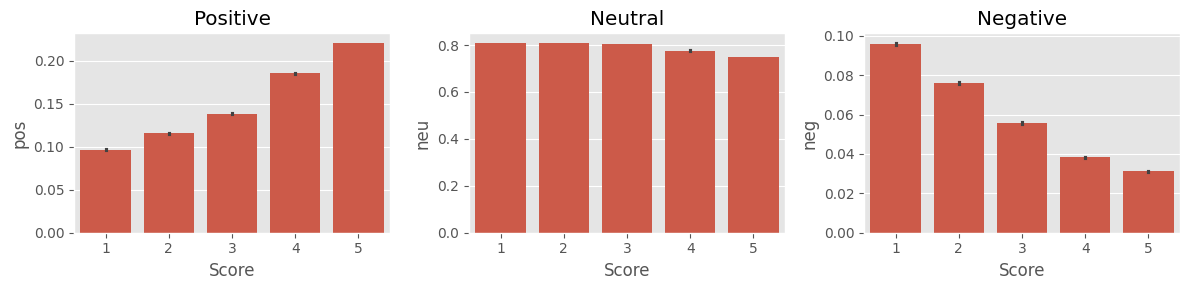

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

# Roberta Pretrained Model

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
example="I am so happy!"

encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.0016519702, 'roberta_neu': 0.006504849, 'roberta_pos': 0.99184316}


In [ ]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [ ]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        myid = row['Id']
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
        roberta_result = polarity_scores_roberta(text)
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')

  0%|          | 0/568454 [00:00<?, ?it/s]

Broke for id 83
Broke for id 187
Broke for id 529
Broke for id 540
Broke for id 746
Broke for id 863
Broke for id 1053
Broke for id 1070
Broke for id 1156
Broke for id 1321
Broke for id 1375
Broke for id 1498
Broke for id 1575
Broke for id 1796
Broke for id 1826
Broke for id 2169
Broke for id 2248
Broke for id 2476
Broke for id 2492
Broke for id 2584
Broke for id 2610
Broke for id 2897
Broke for id 2898
Broke for id 2902
Broke for id 2928
Broke for id 2942
Broke for id 2944
Broke for id 2947
Broke for id 2948
Broke for id 3022
Broke for id 3023
Broke for id 3025
Broke for id 3306
Broke for id 3788
Broke for id 3969
Broke for id 4107
Broke for id 4110
Broke for id 4307
Broke for id 4316
Broke for id 4408
Broke for id 4483
Broke for id 4512
Broke for id 4553
Broke for id 4583
Broke for id 5040
Broke for id 5182
Broke for id 5192
Broke for id 5365
Broke for id 5442
Broke for id 5709
Broke for id 5998
Broke for id 6003
Broke for id 6007
Broke for id 6106
Broke for id 6234
Broke for id 6558

# Random forest

In [5]:
!pip install contractions
!pip install textblob
!pip install vaderSentiment
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
from gensim.models import Word2Vec

In [9]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [11]:

def expand_contractions(text):
    return contractions.fix(text)

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
    return ' '.join(tokens)


In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:

def get_vader_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    return analyzer.polarity_scores(text)['compound']

In [ ]:

df['cleaned_text'] = df['Text'].apply(preprocess_text)

In [ ]:
df['vader_sentiment'] = df['cleaned_text'].apply(get_vader_sentiment)

In [ ]:

vectorizer = TfidfVectorizer(ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df['cleaned_text'])
y = df['vader_sentiment']


y = np.where(y >= 0, 1, 0)


smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y)


X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Hyperparameter tuning with GridSearchCV
param_grid = {"n_estimators": [100, 200, 300], "max_depth": [10, 20, None]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

In [ ]:
#Train Random Forest model on the best parameters from gridsearch
rf_model = RandomForestClassifier(**grid_search.best_params_)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

In [ ]:
joblib.dump((rf_model, vectorizer), "random_forest_model.pkl")

# DisilBERT

In [17]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import torch
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [18]:
def expand_contractions(text):
    return contractions.fix(text)

# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = expand_contractions(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

df['cleaned_text'] = df['Text'].apply(preprocess_text)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx]-1, dtype=torch.long)
        return item


In [30]:
df['Score'].unique()

array([5, 1, 4, 2, 3])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['Score'], test_size=0.2, random_state=42)
train_dataset = SentimentDataset(X_train.tolist(), y_train.tolist(), tokenizer)
test_dataset = SentimentDataset(X_test.tolist(), y_test.tolist(), tokenizer)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss


In [ ]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

trainer.evaluate()

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT model and tokenizer
MODEL = "distilbert-base-uncased"  # Or a fine-tuned version
tokenizer = DistilBertTokenizer.from_pretrained(MODEL)
model = DistilBertForSequenceClassification.from_pretrained(MODEL)

# Save the model and tokenizer to a local directory
save_directory = "./saved_distilbert_model"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

print(f"DistilBERT model and tokenizer saved to {save_directory}")
